# Introduction to Intake-ESM

**Max Grover**

**08 December 2021**

---

# Overview

1. What is Intake-ESM?
2. How can we use it to read in data?
3. How do we work with dictionaries of datasets?
4. How do I write my analysis to work with Intake-ESM?

# Prerequisites

|Concepts | Importance | Notes |
| --- | --- | --- |
| [Introduction to Xarray](https://foundations.projectpythia.org/core/xarray/xarray.html) | Necessary | - |
| [Introduction to Matplotlib](https://foundations.projectpythia.org/core/matplotlib/matplotlib.html) | Helpful | - |

- Time to learn: 50 minutes.

---

# Setup

## Imports

Here, we will import `intake`, and `dask.distributed` (`distributed`)

Remember, `Intake-ESM` is a **plugin** within the [`Intake`](https://intake.readthedocs.io/en/latest/index.html) project, so we do not need to explicitly call

```python
import intake_esm
```

In [1]:
import intake
from distributed import Client, LocalCluster
import xarray as xr
import matplotlib.pyplot as plt
import fsspec

## Spin up a Dask Cluster
We will go ahead and spin up a Dask Cluster

In [2]:
cluster = LocalCluster()
client = Client(cluster)
client

/Users/mgrover/anaconda3/envs/pythia-intake-esm-tutorial/lib/python3.10/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 60785 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:60785/status,
Dashboard: http://127.0.0.1:60785/status,Workers: 4
Total threads: 16,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:60786,Workers: 4
Dashboard: http://127.0.0.1:60785/status,Total threads: 16
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:60802,Total threads: 4
Dashboard: http://127.0.0.1:60805/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:60791,


# What is Intake-ESM?

Be sure to make your examples and lessons targed to an atmospheric and oceanic science audience. We want to keep things as relevant and interesting as possible to our attendees. Keep in mind that many scientists will want to copy and paste code from these lessons, and then make small edits so it works for their particular specific analysis.

# How can I use Intake-ESM to read in my data?

## "Traditional" Workflow
Say, for example, wanted to take a look at data from the AWS hosted Community Earth System Model Large Ensemble (CESM-LENS)...

We want to take a look at:
* Atmospheric temperature (`T`)
* Atmospheric moisture (`Q`)

As well as:
* Ocean temperature (`TEMP`)
* Ocean salinity (`SALT`)


### Investigate the files on AWS
We use `fsspec` here to take a look at what files are available; this would be similar to listing files on your local system (ex. `glob`)

In [11]:
fs = fsspec.filesystem('s3', anon=True)
bucket = 'ncar-cesm-lens'
fs.ls(bucket)

['ncar-cesm-lens/atm',
 'ncar-cesm-lens/catalogs',
 'ncar-cesm-lens/ice_nh',
 'ncar-cesm-lens/ice_sh',
 'ncar-cesm-lens/lnd',
 'ncar-cesm-lens/ocn']

You'll notice we have a few directories in this bucket, corresponding to each component:
* Atmosphere (`atm`)
* Ice Northern Hemisphere (`ice_nh`)
* Ice Southern Hemisphere (`ice_sh`)
* Land (`lnd`)
* Ocean (`ocn`)

If we go into the `atm` directory, we see there are various frequencies which each component as well

In [12]:
bucket = 'ncar-cesm-lens/atm'
fs.ls(bucket)

['ncar-cesm-lens/atm/',
 'ncar-cesm-lens/atm/daily',
 'ncar-cesm-lens/atm/hourly6-1990-2005',
 'ncar-cesm-lens/atm/hourly6-2026-2035',
 'ncar-cesm-lens/atm/hourly6-2071-2080',
 'ncar-cesm-lens/atm/monthly',
 'ncar-cesm-lens/atm/static']

If we go one level further, we see the actual data, separated by `cesmLE-{experiment}-{variable}.zarr`

In [13]:
bucket = 'ncar-cesm-lens/atm/monthly'
fs.ls(bucket)

['ncar-cesm-lens/atm/monthly/',
 'ncar-cesm-lens/atm/monthly/cesmLE-20C-FLNS.zarr',
 'ncar-cesm-lens/atm/monthly/cesmLE-20C-FLNSC.zarr',
 'ncar-cesm-lens/atm/monthly/cesmLE-20C-FLUT.zarr',
 'ncar-cesm-lens/atm/monthly/cesmLE-20C-FSNS.zarr',
 'ncar-cesm-lens/atm/monthly/cesmLE-20C-FSNSC.zarr',
 'ncar-cesm-lens/atm/monthly/cesmLE-20C-FSNTOA.zarr',
 'ncar-cesm-lens/atm/monthly/cesmLE-20C-ICEFRAC.zarr',
 'ncar-cesm-lens/atm/monthly/cesmLE-20C-LHFLX.zarr',
 'ncar-cesm-lens/atm/monthly/cesmLE-20C-PRECC.zarr',
 'ncar-cesm-lens/atm/monthly/cesmLE-20C-PRECL.zarr',
 'ncar-cesm-lens/atm/monthly/cesmLE-20C-PRECSC.zarr',
 'ncar-cesm-lens/atm/monthly/cesmLE-20C-PRECSL.zarr',
 'ncar-cesm-lens/atm/monthly/cesmLE-20C-PSL.zarr',
 'ncar-cesm-lens/atm/monthly/cesmLE-20C-Q.zarr',
 'ncar-cesm-lens/atm/monthly/cesmLE-20C-SHFLX.zarr',
 'ncar-cesm-lens/atm/monthly/cesmLE-20C-T.zarr',
 'ncar-cesm-lens/atm/monthly/cesmLE-20C-TMQ.zarr',
 'ncar-cesm-lens/atm/monthly/cesmLE-20C-TREFHT.zarr',
 'ncar-cesm-lens/atm/mo

### Loading in Data Using Xarray
Let's say we wanted to look at data from the historical scenario (`HIST`)... We could load the data using the following syntax!

In [14]:
var = 'T'
atmosphere_ds = xr.open_zarr(f's3://ncar-cesm-lens/atm/monthly/cesmLE-RCP85-{var}.zarr', storage_options={'anon':True})
atmosphere_ds

<xarray.Dataset>
Dimensions:    (member_id: 40, time: 1140, lev: 30, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lev        (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
  * time       (time) object 2006-01-16 12:00:00 ... 2100-12-16 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1140, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    T          (member_id, time, lev, lat, lon) float32 dask.array<chunksize=(1, 18, 30, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.0
    NCO:                       4.3.4
    Version:                   $Name$
    host:                      tcs-f02n07
    important_note:            This data is part of the project 'Blind Evalua...
    initial_file:              b.e11.B20TRC5CNBDRD.f09_g16.105.cam.i.2006-01-...
    logname:                   mudryk
    nco_openmp_thread_number:  1
    revision_Id:               $Id$
    source:                    CAM
    title:                     UNSET
    topography_file:           /scratch/p/pjk/mudryk/cesm1_1_2_LENS/inputdata...

If we wanted all of these in the same dataset, we would need to write the merging ourselves

In [15]:
variables = ['T', 'Q']
ds_list = []

# Loop through the different files and add them to the list of datasets
for var in variables:
    ds_list.append(xr.open_zarr(f's3://ncar-cesm-lens/atm/monthly/cesmLE-RCP85-{var}.zarr', storage_options={'anon':True}))
    
atmosphere_merged = xr.merge(ds_list)
atmosphere_merged

<xarray.Dataset>
Dimensions:    (member_id: 40, time: 1140, lev: 30, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lev        (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
  * time       (time) object 2006-01-16 12:00:00 ... 2100-12-16 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1140, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    T          (member_id, time, lev, lat, lon) float32 dask.array<chunksize=(1, 18, 30, 192, 288), meta=np.ndarray>
    Q          (member_id, time, lev, lat, lon) float32 dask.array<chunksize=(1, 18, 30, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.0
    NCO:                       4.3.4
    Version:                   $Name$
    host:                      tcs-f02n07
    important_note:            This data is part of the project 'Blind Evalua...
    initial_file:              b.e11.B20TRC5CNBDRD.f09_g16.105.cam.i.2006-01-...
    logname:                   mudryk
    nco_openmp_thread_number:  1
    revision_Id:               $Id$
    source:                    CAM
    title:                     UNSET
    topography_file:           /scratch/p/pjk/mudryk/cesm1_1_2_LENS/inputdata...

That wasn't ***too*** bad, what if we wanted to look look at other experiments? Or other components, such as the ocean? It gets tricky...
* Experiments have different time ranges
* Components have different grids

Let's load in an ocean temperature dataset...

In [16]:
ocean_ds = xr.open_zarr(f's3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-TEMP.zarr', storage_options={'anon':True})
ocean_ds

<xarray.Dataset>
Dimensions:     (member_id: 40, time: 1140, z_t: 60, nlat: 384, nlon: 320, d2: 2)
Coordinates:
  * member_id   (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
  * time        (time) object 2006-01-16 12:00:00 ... 2100-12-16 12:00:00
    time_bound  (time, d2) object dask.array<chunksize=(1140, 2), meta=np.ndarray>
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    TEMP        (member_id, time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 6, 60, 384, 320), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netc...
    NCO:                       4.3.4
    calendar:                  All years have exactly  365 days.
    cell_methods:              cell_methods = time: mean ==> the variable val...
    contents:                  Diagnostic and Prognostic Variables
    nco_openmp_thread_number:  1
    nsteps_total:              750
    revision:                  $Id: tavg.F90 41939 2012-11-14 16:37:23Z mlevy...
    source:                    CCSM POP2, the CCSM Ocean Component
    start_time:                This dataset was created on 2014-12-26 at 15:5...
    tavg_sum:                  2592000.0
    tavg_sum_qflux:            2592000.0

Notice how we now have dimensions (`time`, `z_t`, `nlat`, `nlon`), which differs from the atmosphere dataset (`time`, `lev`, `lat`, `lon`)

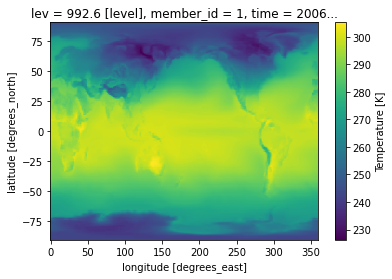

In [9]:
atmosphere_ds.isel(member_id=0, time=0, lev=-1).T.plot();

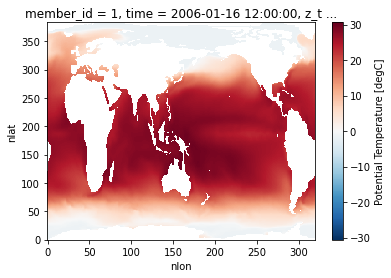

In [10]:
ocean_ds.isel(member_id=0, time=0, z_t=0).TEMP.plot();

What if there were an easier way of searching for available data, as well as loading the data into your analysis to make it easier to generalize? This is where `Intake-ESM` comes in!

## Intake-ESM Method
We can use the Intake-ESM catalog from the CESM-LENS dataset (`https://raw.githubusercontent.com/NCAR/cesm-lens-aws/master/intake-catalogs/aws-cesm1-le.json`) to work with these data!

In [56]:
data_catalog = intake.open_esm_datastore('https://raw.githubusercontent.com/NCAR/cesm-lens-aws/master/intake-catalogs/aws-cesm1-le.json')
data_catalog

,unique
variable,78
long_name,75
component,5
experiment,4
frequency,6
vertical_levels,3
spatial_domain,5
units,25
start_time,12
end_time,13


You'll notice that this catalog has 5 components, and six frequencies as we mentioned earlier. If we call `.df` on this catalog, we can see the table of metadata!

In [57]:
data_catalog.df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,FLNS,net longwave flux at surface,atm,20C,daily,1.0,global,W/m2,1920-01-01 12:00:00,2005-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FLNS....
1,FLNSC,clearsky net longwave flux at surface,atm,20C,daily,1.0,global,W/m2,1920-01-01 12:00:00,2005-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FLNSC...
2,FLUT,upwelling longwave flux at top of model,atm,20C,daily,1.0,global,W/m2,1920-01-01 12:00:00,2005-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FLUT....
3,FSNS,net solar flux at surface,atm,20C,daily,1.0,global,W/m2,1920-01-01 12:00:00,2005-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FSNS....
4,FSNSC,clearsky net solar flux at surface,atm,20C,daily,1.0,global,W/m2,1920-01-01 12:00:00,2005-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FSNSC...
...,...,...,...,...,...,...,...,...,...,...,...
437,WVEL,vertical velocity,ocn,RCP85,monthly,60.0,global_ocean,centimeter/s,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-W...
438,NaN,NaN,ocn,CTRL,static,NaN,global_ocean,NaN,NaN,NaN,s3://ncar-cesm-lens/ocn/static/grid.zarr
439,NaN,NaN,ocn,HIST,static,NaN,global_ocean,NaN,NaN,NaN,s3://ncar-cesm-lens/ocn/static/grid.zarr
440,NaN,NaN,ocn,RCP85,static,NaN,global_ocean,NaN,NaN,NaN,s3://ncar-cesm-lens/ocn/static/grid.zarr


## Searching for your Data
We can use the `.search` API to search for the data we are interested in. In this case, as mentioned before, we are interested in future data (`RCP85`) from the atmosphere and ocean

In [58]:
data_catalog_subset = data_catalog.search(variable=['T', 'Q', 'TEMP', 'SALT'],
                                          frequency='monthly',)
data_catalog_subset.df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,Q,specific humidity,atm,20C,monthly,30.0,global,kg/kg,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/atm/monthly/cesmLE-20C-Q.zarr
1,T,temperature,atm,20C,monthly,30.0,global,K,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/atm/monthly/cesmLE-20C-T.zarr
2,Q,specific humidity,atm,CTRL,monthly,30.0,global,kg/kg,0400-01-16 12:00:00,2200-12-16 12:00:00,s3://ncar-cesm-lens/atm/monthly/cesmLE-CTRL-Q....
3,T,temperature,atm,CTRL,monthly,30.0,global,K,0400-01-16 12:00:00,2200-12-16 12:00:00,s3://ncar-cesm-lens/atm/monthly/cesmLE-CTRL-T....
4,Q,specific humidity,atm,HIST,monthly,30.0,global,kg/kg,1850-01-16 12:00:00,1919-12-16 12:00:00,s3://ncar-cesm-lens/atm/monthly/cesmLE-HIST-Q....
5,T,temperature,atm,HIST,monthly,30.0,global,K,1850-01-16 12:00:00,1919-12-16 12:00:00,s3://ncar-cesm-lens/atm/monthly/cesmLE-HIST-T....
6,Q,specific humidity,atm,RCP85,monthly,30.0,global,kg/kg,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/atm/monthly/cesmLE-RCP85-Q...
7,T,temperature,atm,RCP85,monthly,30.0,global,K,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/atm/monthly/cesmLE-RCP85-T...
8,SALT,salinity,ocn,20C,monthly,60.0,global_ocean,gram/kilogram,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-SAL...
9,TEMP,potential temperature,ocn,20C,monthly,60.0,global_ocean,degC,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-TEM...


We can take a look at our catalog dataframe again, to verify we have the datasets we are looking for!

In [59]:
data_catalog_subset.df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,Q,specific humidity,atm,20C,monthly,30.0,global,kg/kg,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/atm/monthly/cesmLE-20C-Q.zarr
1,T,temperature,atm,20C,monthly,30.0,global,K,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/atm/monthly/cesmLE-20C-T.zarr
2,Q,specific humidity,atm,CTRL,monthly,30.0,global,kg/kg,0400-01-16 12:00:00,2200-12-16 12:00:00,s3://ncar-cesm-lens/atm/monthly/cesmLE-CTRL-Q....
3,T,temperature,atm,CTRL,monthly,30.0,global,K,0400-01-16 12:00:00,2200-12-16 12:00:00,s3://ncar-cesm-lens/atm/monthly/cesmLE-CTRL-T....
4,Q,specific humidity,atm,HIST,monthly,30.0,global,kg/kg,1850-01-16 12:00:00,1919-12-16 12:00:00,s3://ncar-cesm-lens/atm/monthly/cesmLE-HIST-Q....
5,T,temperature,atm,HIST,monthly,30.0,global,K,1850-01-16 12:00:00,1919-12-16 12:00:00,s3://ncar-cesm-lens/atm/monthly/cesmLE-HIST-T....
6,Q,specific humidity,atm,RCP85,monthly,30.0,global,kg/kg,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/atm/monthly/cesmLE-RCP85-Q...
7,T,temperature,atm,RCP85,monthly,30.0,global,K,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/atm/monthly/cesmLE-RCP85-T...
8,SALT,salinity,ocn,20C,monthly,60.0,global_ocean,gram/kilogram,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-SAL...
9,TEMP,potential temperature,ocn,20C,monthly,60.0,global_ocean,degC,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-TEM...


## Load in the Data
Now that we have subset our catalog, we can load the data into our notebook using ***`.to_dataset_dict()`*** which is short for "to dataset dictionary"

`Intake-ESM` ***aggregates*** these datasets by `component`, `experiment`, and `frequency`, and provides a nice progress bar to check in on the data access process!

In [60]:
dsets = data_catalog_subset.to_dataset_dict(storage_options={'anon':True})
dsets


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'


{'ocn.HIST.monthly': <xarray.Dataset>
 Dimensions:     (time: 840, z_t: 60, nlat: 384, nlon: 320, d2: 2)
 Coordinates:
     member_id   int64 ...
   * time        (time) object 1850-01-16 12:00:00 ... 1919-12-16 12:00:00
     time_bound  (time, d2) object dask.array<chunksize=(840, 2), meta=np.ndarray>
   * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
 Dimensions without coordinates: nlat, nlon, d2
 Data variables:
     SALT        (time, z_t, nlat, nlon) float32 dask.array<chunksize=(6, 60, 384, 320), meta=np.ndarray>
     TEMP        (time, z_t, nlat, nlon) float32 dask.array<chunksize=(6, 60, 384, 320), meta=np.ndarray>
 Attributes:
     Conventions:               CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netc...
     source:                    CCSM POP2, the CCSM Ocean Component
     tavg_sum:                  2592000.0
     cell_methods:              cell_methods = time: mean ==> the variable val...
     contents:                  Diagnostic and Prognost

# How do we work with dictionaries of datasets?

The result of `.to_dataset_dict()` is a dictionary of datasets, organized via `key:xarray.Dataset`

For example, we see that our dictionary of datasets has two keys, corresponding to atmospheric, and oceanic components respectively

In [61]:
dsets.keys()

dict_keys(['ocn.HIST.monthly', 'ocn.RCP85.monthly', 'atm.RCP85.monthly', 'atm.20C.monthly', 'ocn.20C.monthly', 'atm.HIST.monthly', 'ocn.CTRL.monthly', 'atm.CTRL.monthly'])

We can access the `xarray.Datasets` within our dictionary by using these keys! For example, let's take a look at the atmospheric data.

In [62]:
atmosphere_dset = dsets['atm.RCP85.monthly']
atmosphere_dset

<xarray.Dataset>
Dimensions:    (member_id: 40, time: 1140, lev: 30, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lev        (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
  * time       (time) object 2006-01-16 12:00:00 ... 2100-12-16 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1140, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    Q          (member_id, time, lev, lat, lon) float32 dask.array<chunksize=(1, 18, 30, 192, 288), meta=np.ndarray>
    T          (member_id, time, lev, lat, lon) float32 dask.array<chunksize=(1, 18, 30, 192, 288), meta=np.ndarray>
Attributes: (12/14)
    Conventions:               CF-1.0
    host:                      tcs-f02n07
    NCO:                       4.3.4
    revision_Id:               $Id$
    important_note:            This data is part of the project 'Blind Evalua...
    logname:                   mudryk
    ...                        ...
    nco_openmp_thread_number:  1
    title:                     UNSET
    initial_file:              b.e11.B20TRC5CNBDRD.f09_g16.105.cam.i.2006-01-...
    intake_esm_varname:        Q\nT
    source:                    CAM
    intake_esm_dataset_key:    atm.RCP85.monthly

Our dataset has both temperature (`T`), and specific humidity (`Q`) within it! We can follow the same process for the ocean data...

In [63]:
ocean_dset = dsets['ocn.RCP85.monthly']
ocean_dset

<xarray.Dataset>
Dimensions:     (member_id: 40, time: 1140, z_t: 60, nlat: 384, nlon: 320, d2: 2)
Coordinates:
  * member_id   (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
  * time        (time) object 2006-01-16 12:00:00 ... 2100-12-16 12:00:00
    time_bound  (time, d2) object dask.array<chunksize=(1140, 2), meta=np.ndarray>
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    SALT        (member_id, time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 6, 60, 384, 320), meta=np.ndarray>
    TEMP        (member_id, time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 6, 60, 384, 320), meta=np.ndarray>
Attributes: (12/14)
    Conventions:               CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netc...
    source:                    CCSM POP2, the CCSM Ocean Component
    tavg_sum:                  2592000.0
    cell_methods:              cell_methods = time: mean ==> the variable val...
    NCO:                       4.3.4
    contents:                  Diagnostic and Prognostic Variables
    ...                        ...
    nco_openmp_thread_number:  1
    start_time:                This dataset was created on 2014-12-26 at 15:5...
    revision:                  $Id: tavg.F90 41939 2012-11-14 16:37:23Z mlevy...
    intake_esm_varname:        SALT\nTEMP
    tavg_sum_qflux:            2592000.0
    intake_esm_dataset_key:    ocn.RCP85.monthly

# How do I write analysis code to work with Intake-ESM?
What if we wanted to look at a timeseries of atmospheric data, including both the historical and future scenarios... We need to follow the same few steps
1. Read in the catalog
2. Search for our data using `.search()`
3. Load in the data using `.to_dataset_dict()`

## Search for Monthly Atmospheric Data
We restrict the search to atmospheric temperature and specific humidity

In [64]:
data_catalog_subset = data_catalog.search(component='atm',
                                          variable=['T', 'Q'],
                                          frequency='monthly',
                                          experiment=['RCP85', '20C'])
data_catalog_subset.df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,Q,specific humidity,atm,20C,monthly,30.0,global,kg/kg,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/atm/monthly/cesmLE-20C-Q.zarr
1,T,temperature,atm,20C,monthly,30.0,global,K,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/atm/monthly/cesmLE-20C-T.zarr
2,Q,specific humidity,atm,RCP85,monthly,30.0,global,kg/kg,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/atm/monthly/cesmLE-RCP85-Q...
3,T,temperature,atm,RCP85,monthly,30.0,global,K,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/atm/monthly/cesmLE-RCP85-T...


## Load the Data using `.to_dataset_dict()`
Similar to before, we load in our dictionary of datasets!

In [65]:
dsets = data_catalog_subset.to_dataset_dict(storage_options={'anon':True})
dsets


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'


{'atm.20C.monthly': <xarray.Dataset>
 Dimensions:    (member_id: 40, time: 1032, lev: 30, lat: 192, lon: 288, nbnd: 2)
 Coordinates:
   * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
   * lev        (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
   * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
   * member_id  (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
   * time       (time) object 1920-01-16 12:00:00 ... 2005-12-16 12:00:00
     time_bnds  (time, nbnd) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
 Dimensions without coordinates: nbnd
 Data variables:
     Q          (member_id, time, lev, lat, lon) float32 dask.array<chunksize=(1, 18, 30, 192, 288), meta=np.ndarray>
     T          (member_id, time, lev, lat, lon) float32 dask.array<chunksize=(1, 18, 30, 192, 288), meta=np.ndarray>
 Attributes: (12/13)
     Conventions:               CF-1.0
     NCO:                       4.3.4

## Build a Function to Operator on a Single Dataset
A good practice is to write a function which works with a single dataset. Let's work on an example.

In [66]:
historical_ds = dsets['atm.20C.monthly']
historical_ds

<xarray.Dataset>
Dimensions:    (member_id: 40, time: 1032, lev: 30, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lev        (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
  * time       (time) object 1920-01-16 12:00:00 ... 2005-12-16 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    Q          (member_id, time, lev, lat, lon) float32 dask.array<chunksize=(1, 18, 30, 192, 288), meta=np.ndarray>
    T          (member_id, time, lev, lat, lon) float32 dask.array<chunksize=(1, 18, 30, 192, 288), meta=np.ndarray>
Attributes: (12/13)
    Conventions:               CF-1.0
    NCO:                       4.3.4
    revision_Id:               $Id$
    important_note:            This data is part of the project 'Blind Evalua...
    logname:                   mudryk
    Version:                   $Name$
    ...                        ...
    nco_openmp_thread_number:  1
    title:                     UNSET
    initial_file:              b.e11.B20TRC5CNBDRD.f09_g16.001.cam.i.1920-01-...
    intake_esm_varname:        Q\nT
    source:                    CAM
    intake_esm_dataset_key:    atm.20C.monthly

Let's write a simple function to subset for the lowest level (`.isel(lev=-1)`), and select a lat/lon point of our choosing.

We can do this with only this with the following syntax:

In [67]:
lat = 40.0150
lon = 105.2705
variable = 'T'

ds = historical_ds.isel(member_id=0, lev=-1).sel(lat=lat, lon=lon, method='nearest')[variable]
ds.isel(time=range(10)).plot()

KeyboardInterrupt: 

In [33]:
ds['time'] = ds.indexes['time'].to_datetimeindex()

/var/folders/yp/gtfjd3rd1mb7_fqcslznzrz40000gq/T/ipykernel_27532/2135622427.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds['time'] = ds.indexes['time'].to_datetimeindex()


As a function, this would accept a dataset, with a few parameters. We will also subset for the first 5 years (`range(60)`) for the sake of time.

In [41]:
def plot_point_timeseries(ds, variable, lat=40.015, lon = 105.2705):
    ds_subset = ds.isel(lev=-1,time=range(60)).sel(lat=lat, lon=lon, method='nearest')[variable]
    ds_subset['time'] = ds_subset.indexes['time'].to_datetimeindex()
    return ds_subset.plot(figsize=(10,8))

/var/folders/yp/gtfjd3rd1mb7_fqcslznzrz40000gq/T/ipykernel_27532/130672294.py:3: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds_subset['time'] = ds_subset.indexes['time'].to_datetimeindex()


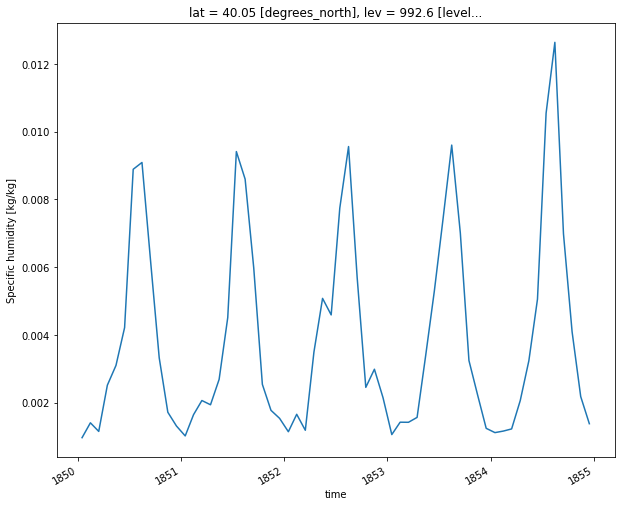

In [42]:
plot_point_timeseries(historical_ds, variable='Q');

## Loop through the Dictionary of Datasets to Apply this Function

/var/folders/yp/gtfjd3rd1mb7_fqcslznzrz40000gq/T/ipykernel_35872/1350178360.py:3: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds_subset['time'] = ds_subset.indexes['time'].to_datetimeindex()


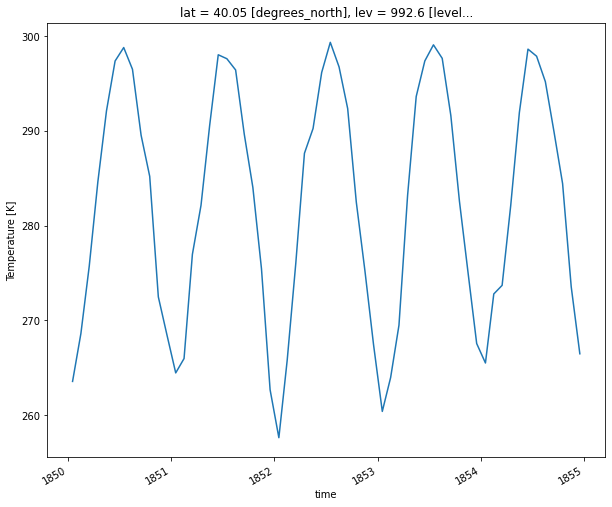

/var/folders/yp/gtfjd3rd1mb7_fqcslznzrz40000gq/T/ipykernel_35872/1350178360.py:3: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds_subset['time'] = ds_subset.indexes['time'].to_datetimeindex()


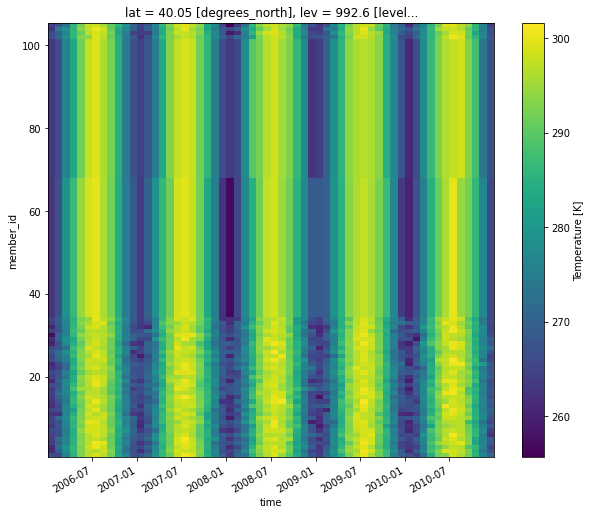

In [56]:
# Loop through the different keys in the dictionary of datasets
for key in dsets.keys():
    plot = plot_point_timeseries(dsets[key], variable='T')
    plt.show()
    plt.close()

---

# Summary

Within this tutorial, we covered how `Intake-ESM` is useful, how to search for data, load your data into a dictionary of datasets, and write functions to plot your output.

## Resources and references
* [Intake-ESM Documentation](https://intake-esm.readthedocs.io/en/stable/)
* [List of Available Catalogs](https://intake-esm.readthedocs.io/en/stable/supplemental-guide/faq.html#is-there-a-list-of-existing-catalogs)
* [ESDS Blog Posts Related to Intake-ESM](https://ncar.github.io/esds/blog/tag/intake/)
* [Pangeo Gallery Intake-ESM]()
* [CMIP6 Pre-Processing]()

[Intake-ESM Citation](https://doi.org/10.5281/zenodo.3491062)